In [1]:
%load_ext autoreload
%autoreload 2.0
%matplotlib inline

In [59]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import sys
sys.path.insert(0, '../.')
from data.detection_dataset_loader import *
from scipy.spatial.transform import Rotation as R
from data.data_utils.data_reader import *
from data.data_utils.reader_utils import *
import math
import numpy.matlib as npm


In [3]:
def convert5Pointto8Point(cx_, cy_, w_, h_, a_):

    theta = math.radians(a_)
    bbox = npm.repmat([[cx_], [cy_]], 1, 5) + \
       np.matmul([[math.cos(theta), math.sin(theta)],
                  [-math.sin(theta), math.cos(theta)]],
                 [[-w_ / 2, w_/ 2, w_ / 2, -w_ / 2, w_ / 2 + 8],
                  [-h_ / 2, -h_ / 2, h_ / 2, h_ / 2, 0]])
    # add first point
    x1, y1 = bbox[0][0], bbox[1][0]
    # add second point
    x2, y2 = bbox[0][1], bbox[1][1]
    # add third point
    #x3, y3 = bbox[0][4], bbox[1][4]   
    # add forth point
    x3, y3 = bbox[0][2], bbox[1][2]
    # add fifth point
    x4, y4 = bbox[0][3], bbox[1][3]

    return [x1, y1, x2, y2, x3, y3, x4, y4]


In [234]:
def get_augmentation_parameters( training):
        if training:

                    if np.random.random_sample() >= 0.5:
                        image_translate_x = random.randint(-50, 50)
                    else:
                        image_translate_x = 0
                    if np.random.random_sample() >= 0.5:
                        image_translate_y = random.randint(-25, 25)
                    else:
                        image_translate_y = 0

                    if np.random.random_sample() >= 0.5:
                        translate_x = random.randint(-5, 5)
                    else:
                        translate_x = 0
                    if np.random.random_sample() >= 0.5:
                        translate_y = random.randint(-5, 5)
                    else:
                        translate_y = 0

                    if np.random.random_sample() >= 0.8:
                        translate_z = random.random() - 0.5
                    else:
                        translate_z = 0

                    if np.random.random_sample() >= 0.0:
                        ang = random.randint(-50, 50)
                    else:
                        ang = 0

                    r = R.from_rotvec(np.radians(ang) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = translate_x
                    tr_y = translate_y
                    tr_z = translate_z
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
                    
                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    
                    sc_x = 1
                    sc_y = 1
                    sc_z = 1

                    # if np.random.random_sample() >= 0.5:
                    #    sc_x += ((random.random() * 2) - 1.) / 10.

                    # if np.random.random_sample() >= 0.5:
                    #    sc_y += ((random.random() * 2) - 1.) / 10.


                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])
                    

        else:
                    image_translate_x = 0
                    image_translate_y = 0

                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    ang = 0

                    r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = 0
                    tr_y = 0
                    tr_z = 0
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

                    sc_x = 1
                    sc_y = 1
                    sc_z = 1
                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

        return rot, tr, sc, image_translate_x, image_translate_y, ang

In [235]:
training=True
base_path = '../../../Data/'
list_files = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3')))
random.seed(0)
random.shuffle(list_files)

camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
        
ln = int(len(list_files) * 0.5)
final_sample = len(list_files)

# ln = int(10 * 0.5)
# final_sample = 10
        
if training:
            list_files = list_files[:ln]
            list_camera_paths = camera_paths[:ln]
            list_lidar_paths = lidar_paths[:ln]
            list_label_paths = label_paths[:ln]
            list_calib_paths = calib_paths[:ln]
else:
            list_camera_paths = camera_paths[ln:final_sample]
            list_lidar_paths = lidar_paths[ln:final_sample]
            list_label_paths = label_paths[ln:final_sample]
            list_calib_paths = calib_paths[ln:final_sample]
            list_files = list_files[ln:final_sample]


In [109]:
def get_target2(labels, directions, anchors=np.array([3.9, 1.6, 1.5]), input_size=(512, 448), output_size=(128, 112)):
    # ASSUMPTION: I will assume that the anchors contain a record for the height
    """
    - calculate the ratio = input size / final output size
    - divide each of the x, y and z by the ratio
    - subtract each of the x, y and z ....
    """

    ratio = input_size[0] // output_size[0]
    y_target = np.zeros((output_size[0], output_size[1], 2, 9), np.float32)
   
    for i in range(len(labels)):
        label_i = np.array(labels[i])
        print(label_i)

        x = int(label_i[0]/ratio)
        y = int(label_i[1]/ratio)

        if x >= output_size[0]:
            x = output_size[0] - 1
        if y >= output_size[1]:
            y = output_size[1] - 1

        if x < 0 or y < 0:
            continue

        label_i[0:2] = label_i[0:2] / (ratio*1.0)
        label_i[0] = label_i[0] + 0.5
        label_i[3] = label_i[3] * 2
        label_i[2] = label_i[2] / 40.

        if label_i[6] < 0:
            label_i[6] += 3.14

        angle = label_i[6] * 57.2958
        if (angle >= 0 and angle <= 45) or (angle >= 135 and angle <= 225) or (angle >= 315 and angle <= 360):
            k = 0
        else:
            k = 1

        if label_i[6] >= 3 * np.pi / 4:
            label_i[6] = label_i[6] - np.pi
        
        label_i[6] = label_i[6] - k * (np.pi/2)

        anchor = np.array([x+0.5, y+0.5, 1., anchors[0], anchors[1], anchors[2]])
    
        label_i[:3] = (label_i[:3] - anchor[:3]) / anchor[3:6]
        label_i[3:6] = np.log(label_i[3:6]/anchors)

        y_target[x, y, k, :7] = label_i
        y_target[x, y, k, 7:8] = [directions[i]]
        y_target[x, y, k, 8:9] = [1]
        print(x, y, k, y_target[x, y, k, :])
    return y_target

In [110]:
# data = np.fromfile(list_lidar_paths[i_c], dtype=np.float32).reshape(-1, 4)
# x = data[:, 0]
# y = data[:, 1]
# z = data[:, 2]
# i = data[:, 3]
# i = i[x >= 0]
# y = y[x >= 0]
# z = z[x >= 0]
# x = x[x >= 0]
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import proj3d

# fig = plt.figure(figsize=(8, 8))

# # ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(x, y, z, s=1)

# ax = fig.add_subplot(111)
# ax.scatter(x, y, s=0.5)

# plt.show()

In [111]:
# np.max(x), np.min(x), np.max(y), np.min(y), np.max(z), np.min(z), np.max(i), np.min(i)

In [112]:
import numpy as np
import math
from scipy.ndimage import rotate
import cv2
from data.data_utils.fv_utils import *

class LidarReader:

    def __init__(self, lidar_path, calib_path, image_path, rot, tr, sc, 
                        x_range=(0, 71), 
                        y_range=(-40, 40), 
                        z_range=(-3.0, 1), 
                        size=(512, 448, 40)):
        self.lidar_path = lidar_path
        self.calib_path = calib_path
        self.image_path = image_path
        self.rot = rot
        self.sc = sc
        self.tr = tr
        self.x_range = x_range
        self.y_range = y_range
        self.z_range = z_range
        self.size = size



    def read_lidar(self):

        points = np.fromfile(self.lidar_path, dtype=np.float32).reshape(-1, 4)
        calib = Calibration(self.calib_path)
        img_height, img_width, _ = cv2.imread(self.image_path).shape
        imgfov_pc_velo, pts_2d, fov_inds = get_lidar_in_image_fov(points[:, :3],
            calib, 0, 0, img_width, img_height, True)

        points = points[fov_inds, :]
        points = (points.transpose() + self.tr).transpose()
        points = np.matmul(self.rot, points.transpose()).transpose()
        points = np.matmul(self.sc, points.transpose()).transpose()
        x = points[:, 0]
        y = points[:, 1]
        z = points[:, 2]
        intensity = points[:, 3]
        
        x_lim = self.in_range_points(x, x, y, z, self.x_range, self.y_range, self.z_range)
        y_lim = self.in_range_points(y, x, y, z, self.x_range, self.y_range, self.z_range)
        z_lim = self.in_range_points(z, x, y, z, self.x_range, self.y_range, self.z_range)
        i_lim = self.in_range_points(intensity, x, y, z, self.x_range, self.y_range, self.z_range)
        
        x_size = (self.x_range[1] - self.x_range[0])
        y_size = (self.y_range[1] - self.y_range[0])
        z_size = (self.z_range[1] - self.z_range[0])
            
        x_fac = (self.size[0]-1) / x_size
        y_fac = (self.size[1]-1) / y_size
        z_fac = (self.size[2]-1) / z_size

        x_lim = x_lim + -1*self.x_range[0]
        y_lim = y_lim + -1*self.y_range[0]
        z_lim = z_lim + -1*self.z_range[0]
                    
        x_lim = -1 * (x_lim * x_fac).astype(np.int32)
        y_lim = -1 * (y_lim * y_fac).astype(np.int32)
        z_lim = -1 * (z_lim * z_fac).astype(np.int32)
        
        x_lim2 = x_lim[:]
        y_lim2 = y_lim[:]
        z_lim2 = z_lim[:]
        i_lim2 = i_lim[:]

        x_lim = x_lim[(x_lim2>-self.size[0]) & (x_lim2<= 0) & (y_lim2>-self.size[1]) & (y_lim2 <= 0) & (z_lim2>-self.size[2]) & (z_lim2 <= 0)]
        y_lim = y_lim[(x_lim2>-self.size[0]) & (x_lim2<= 0) & (y_lim2>-self.size[1]) & (y_lim2 <= 0) & (z_lim2>-self.size[2]) & (z_lim2 <= 0)]
        z_lim = z_lim[(x_lim2>-self.size[0]) & (x_lim2<= 0) & (y_lim2>-self.size[1]) & (y_lim2 <= 0) & (z_lim2>-self.size[2]) & (z_lim2 <= 0)]
        i_lim = i_lim[(x_lim2>-self.size[0]) & (x_lim2<= 0) & (y_lim2>-self.size[1]) & (y_lim2 <= 0) & (z_lim2>-self.size[2]) & (z_lim2 <= 0)]
        
        print(np.max(i_lim), np.min(i_lim))
        
        img = np.zeros([self.size[0], self.size[1], self.size[2]], dtype=np.float32)
        # occupancy grid
        img[x_lim, y_lim, z_lim] = 255.
#         img[x_lim, y_lim, -1] = i_lim * 255.
#         img = img[:,:, ::-1]
        img = (img - 127.) / 127.
        return img


    def in_range_points(self, points, x, y, z, x_range, y_range, z_range):
        """ 
        This function is imported from https://github.com/windowsub0406/KITTI_Tutorial/blob/master/Convert_Velo_2_Topview_detail.ipynb
        extract in-range points 
        """
        return points[np.logical_and.reduce((x >= x_range[0], x <= x_range[1], y >= y_range[0], \
                                            y <= y_range[1], z >= z_range[0], z <= z_range[1]))]


In [113]:
i_c = 4

In [114]:
rot, tr, sc, image_translate_x, image_translate_y, ang = get_augmentation_parameters(False)
# print(rot)
# print(tr)
# print(sc)
# print(ang)
data_reader_obj = DataReader(list_camera_paths[i_c],
                             list_calib_paths[i_c], 
                             list_label_paths[i_c], 
                             list_lidar_paths[i_c], 
                             rot, sc, tr, ang, image_translate_x, image_translate_y, get_actual_dims=False)
# data_reader_obj.lidar_reader = LidarReader(list_lidar_paths[i_c], list_calib_paths[i_c], list_camera_paths[i_c], rot, tr, sc)
camera_image = data_reader_obj.read_image()
lidar_image = data_reader_obj.lidar_reader.read_lidar()
_, label, directions = data_reader_obj.label_reader.read_label()
label2 = get_target(label, directions,  anchors=np.array([3.9, 1.6, 1.5]))
label3 = get_target2(label, directions,  anchors=np.array([3.9, 1.6, 1.5]))

[472.48097741 249.16122614  27.46689431   3.35         1.65
   1.57         1.72      ]
118 62 1 [ 0.03083188 -0.13105841 -0.20888509  0.54113096  0.03077166  0.04561051
  0.14920367  0.          1.        ]
[424.99293173 211.0514282   26.18942373   3.95         1.7
   1.43         1.76      ]
106 52 1 [ 0.06364947  0.16428566 -0.23017627  0.7058862   0.06062462 -0.04779067
  0.18920368  1.          1.        ]
[391.15559726 257.08777095  26.36418409   3.24         1.6
   1.51         1.7       ]
97 64 1 [ 0.20228188 -0.14253579 -0.2272636   0.50774395  0.          0.00664454
  0.12920368  0.          1.        ]
[351.21319053 262.78402659  25.70871325   4.1          1.74
   1.45         1.75      ]
87 65 1 [ 0.20597374  0.12250415 -0.23818812  0.7431576   0.08388148 -0.03390155
  0.17920367  0.          1.        ]
[339.77201509 222.26754488  26.16483546   3.79         1.68
   1.54         1.78      ]
84 55 1 [ 0.24179584  0.04180389 -0.23058608  0.66453665  0.04879016  0.02631731
  0

In [115]:
if True:
    
        truth = np.array([label2])
        predictions = np.array([label3])
        anchors_size=np.array([3.9, 1.6, 1.5])

        x = truth[:, :, :, :, 0]*anchors_size[0] + 0.5
        x_ = predictions[:, :, :, :, 0] * anchors_size[0] + 0.5
        y = truth[:, :, :, :, 1]*anchors_size[1] + 0.5
        y_ = predictions[:, :, :, :, 1]*anchors_size[1] + 0.5
        z = truth[:, :, :, :, 2]*anchors_size[2] + 1.
        z_ = predictions[:, :, :, :, 2]*anchors_size[2] + 1.

        size_true = np.exp(truth[:, :, :, :, 3:6])*anchors_size
        size_pred = np.exp(predictions[:, :, :, :, 3:6])*anchors_size


        x1 = x + size_true[:, :, :, :, 0]/2
        x2 = x - size_true[:, :, :, :, 0]/2
        y1 = y + size_true[:, :, :, :, 1]/2
        y2 = y - size_true[:, :, :, :, 1]/2
        z1 = z
        z2 = z - size_true[:, :, :, :, 2]

        x1_ = x_ + size_pred[:, :, :, :, 0]/2
        x2_ = x_ - size_pred[:, :, :, :, 0]/2
        y1_ = y_ + size_pred[:, :, :, :, 1]/2
        y2_ = y_ - size_pred[:, :, :, :, 1]/2
        z1_ = z_
        z2_ = z_ - size_pred[:, :, :, :, 2]

        area_g = size_true[:, :, :, :, 0] * size_true[:, :, :, :, 1]
        area_d = size_pred[:, :, :, :, 0] * size_pred[:, :, :, :, 1]
        h_g = size_true[:, :, :, :, 2]
        h_d = size_pred[:, :, :, :, 2]

        area_overlap = np.maximum(0., (np.minimum(x1, x1_) - np.maximum(x2, x2_))) * np.maximum(0., (np.minimum(y1, y1_) - np.maximum(y2, y2_)))
        h_overlap = np.maximum(0., np.minimum(z1, z1_) - np.maximum(z2, z2_))

        iou = (area_overlap * h_overlap) / (area_g*h_g + area_d*h_d - area_overlap*h_overlap + 1e-8)
        iou = np.where(iou >= 0, iou, np.zeros_like(truth[:, :, :, :, 8]))
        iou = np.where(truth[:, :, :, :, 8] >= 0.5, iou, np.zeros_like(truth[:, :, :, :, 8]))
        iou = np.sum(iou) / (np.sum(truth[:, :, :, :, 8])+1e-8)


        x = truth[:, :, :, :, 0]*anchors_size[0] + 0.5
        x_ = predictions[:, :, :, :, 0]*anchors_size[0] + 0.5
        y = truth[:, :, :, :, 1]*anchors_size[1] + 0.5
        y_ = predictions[:, :, :, :, 1]*anchors_size[1] + 0.5
        z = truth[:, :, :, :, 2]*anchors_size[2] + 1.
        z_ = predictions[:, :, :, :, 2]*anchors_size[2] + 1.

        x1 = x + size_true[:, :, :, :, 0]/2
        x2 = x - size_true[:, :, :, :, 0]/2
        y1 = y + size_true[:, :, :, :, 1]/2
        y2 = y - size_true[:, :, :, :, 1]/2
        z1 = z
        z2 = z - size_true[:, :, :, :, 2]

        x1_ = x_ + size_true[:, :, :, :, 0]/2
        x2_ = x_ - size_true[:, :, :, :, 0]/2
        y1_ = y_ + size_true[:, :, :, :, 1]/2
        y2_ = y_ - size_true[:, :, :, :, 1]/2
        z1_ = z_
        z2_ = z_ - size_true[:, :, :, :, 2]

        area_g = size_true[:, :, :, :, 0] * size_true[:, :, :, :, 1]
        area_d = size_true[:, :, :, :, 0] * size_true[:, :, :, :, 1]
        h_g = size_true[:, :, :, :, 2]
        h_d = size_true[:, :, :, :, 2]

        area_overlap = np.maximum(0., (np.minimum(x1, x1_) - np.maximum(x2, x2_))) * np.maximum(0., (np.minimum(y1, y1_) - np.maximum(y2, y2_)))
        h_overlap = np.maximum(0., np.minimum(z1, z1_) - np.maximum(z2, z2_))

        iou_loc = (area_overlap * h_overlap) / (area_g*h_g + area_d*h_d - area_overlap*h_overlap + 1e-8)
        iou_loc = np.where(iou_loc >= 0, iou_loc, np.zeros_like(truth[:, :, :, :, 8]))
        iou_loc = np.where(truth[:, :, :, :, 8] >= 0.5, iou_loc, np.zeros_like(truth[:, :, :, :, 8]))
        iou_loc = np.sum(iou_loc) / (np.sum(truth[:, :, :, :, 8])+1e-8)

        x = truth[:, :, :, :, 0]*anchors_size[0] + 0.5
        y = truth[:, :, :, :, 1]*anchors_size[1] + 0.5
        z = truth[:, :, :, :, 2]*anchors_size[2] + 1.

        size_true = np.exp(truth[:, :, :, :, 3:6])*anchors_size
        size_pred = np.exp(predictions[:, :, :, :, 3:6])*anchors_size


        x1 = x + size_true[:, :, :, :, 0]/2
        x2 = x - size_true[:, :, :, :, 0]/2
        y1 = y + size_true[:, :, :, :, 1]/2
        y2 = y - size_true[:, :, :, :, 1]/2
        z1 = z
        z2 = z - size_true[:, :, :, :, 2]

        x1_ = x + size_pred[:, :, :, :, 0]/2
        x2_ = x - size_pred[:, :, :, :, 0]/2
        y1_ = y + size_pred[:, :, :, :, 1]/2
        y2_ = y - size_pred[:, :, :, :, 1]/2
        z1_ = z
        z2_ = z - size_pred[:, :, :, :, 2]

        area_g = size_true[:, :, :, :, 0] * size_true[:, :, :, :, 1]
        area_d = size_pred[:, :, :, :, 0] * size_pred[:, :, :, :, 1]
        h_g = size_true[:, :, :, :, 2]
        h_d = size_pred[:, :, :, :, 2]

        area_overlap = np.maximum(0., (np.minimum(x1, x1_) - np.maximum(x2, x2_))) * np.maximum(0., (np.minimum(y1, y1_) - np.maximum(y2, y2_)))
        h_overlap = np.maximum(0., np.minimum(z1, z1_) - np.maximum(z2, z2_))

        iou_dim = (area_overlap * h_overlap) / (area_g*h_g + area_d*h_d - area_overlap*h_overlap + 1e-8)
        iou_dim = np.where( iou_dim >= 0, iou_dim, np.zeros_like(truth[:, :, :, :, 8]))
        iou_dim = np.where(truth[:, :, :, :, 8] >= 0.5, iou_dim, np.zeros_like(truth[:, :, :, :, 8]))
        iou_dim = np.sum(iou_dim) / (np.sum(truth[:, :, :, :, 8])+1e-8)

        print(iou, iou_dim, iou_loc)


0.49999999526375555 0.49999999526375555 0.7601667466931498


In [19]:
# label2 = get_target2(label, directions, anchors=np.array([3.9, 1.6, 1.5]))

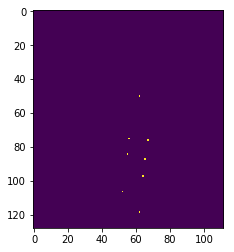

In [20]:
temp = label2[:, :, 1, 8]
# temp = cv2.resize(temp, (448, 512))
plt.imshow(temp)

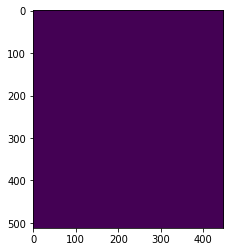

In [21]:
temp = label2[:, :, 0, -1]
temp = cv2.resize(temp, (448, 512))
plt.imshow(temp)

<Figure size 432x288 with 0 Axes>

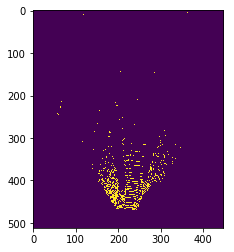

<Figure size 432x288 with 0 Axes>

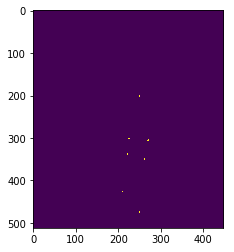

In [22]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)
img = (lidar_image*127. + 127.)
img = img[:, :, 0]
plt.imshow(img>=150)
plt.show()

plt.clf()
fig,ax = plt.subplots(1)
temp = label2[:, :, 1, -1]
temp = cv2.resize(temp, (448, 512)) * 255.
plt.imshow(temp>100)
plt.show()

In [23]:
(26.25161283/40 - 1) / 1.5

-0.22913978616666672

In [24]:
-0.22913978616666672 * 1.5 + 1

0.6562903207499999

In [25]:

# anchors_size=np.array([3.9, 1.6, 1.5])
# truth = np.array([label2])
# predictions = np.array([label3])
# x = truth[:, :, :, :, 0]*anchors_size[0] + 0.5
# x_ = predictions[:, :, :, :, 0] * anchors_size[0] + 0.5
# y = truth[:, :, :, :, 1]*anchors_size[1] + 0.5
# y_ = predictions[:, :, :, :, 1]*anchors_size[1] + 0.5
# z = truth[:, :, :, :, 2]*anchors_size[2] + 1.
# z_ = predictions[:, :, :, :, 2]*anchors_size[2] + 1.

# size_true = np.exp(truth[:, :, :, :, 3:6])*anchors_size
# size_pred = np.exp(predictions[:, :, :, :, 3:6])*anchors_size


# x1 = x + size_true[:, :, :, :, 0]/2
# x2 = x - size_true[:, :, :, :, 0]/2
# y1 = y + size_true[:, :, :, :, 1]/2
# y2 = y - size_true[:, :, :, :, 1]/2
# z1 = z
# z2 = z - size_true[:, :, :, :, 2]

# x1_ = x_ + size_pred[:, :, :, :, 0]/2
# x2_ = x_ - size_pred[:, :, :, :, 0]/2
# y1_ = y_ + size_pred[:, :, :, :, 1]/2
# y2_ = y_ - size_pred[:, :, :, :, 1]/2
# z1_ = z_
# z2_ = z_ - size_pred[:, :, :, :, 2]

# area_g = size_true[:, :, :, :, 0] * size_true[:, :, :, :, 1]
# area_d = size_pred[:, :, :, :, 0] * size_pred[:, :, :, :, 1]
# h_g = size_true[:, :, :, :, 2]
# h_d = size_pred[:, :, :, :, 2]
# area_overlap = np.maximum(0., (np.minimum(x1, x1_) - np.maximum(x2, x2_))) * np.maximum(0., (np.minimum(y1, y1_) - np.maximum(y2, y2_)))
# h_overlap = np.maximum(0., np.minimum(z1, z1_) - np.maximum(z2, z2_))

# iou = (area_overlap * h_overlap) / (area_g*h_g + area_d*h_d - area_overlap*h_overlap + 1e-8)
# iou = np.where(iou > 0, iou, np.zeros_like(truth[:, :, :, :, 8]))
# iou = np.where(truth[:, :, :, :, 8]> 0.5, iou, np.zeros_like(truth[:, :, :, :, 8]))
# iou = np.sum(iou) / (np.sum(truth[:, :, :, :, 8])+1e-8)
# print(iou)

In [26]:
plt.imshow(camera_image)
plt.show()

In [27]:
lidar_image.shape

(512, 448, 41)

In [28]:
np.max(lidar_image), np.min(lidar_image)

(1.0, 0.0)

472.48097740610626 249.16122613804237 27.466894307628436 24.00149925368652 9.28681659952163 15.30581085852821 -98.54877600000002
424.9929317312524 211.05142819540308 26.18942373151885 28.22771262209276 9.607855791839205 13.940961482608502 -100.840608
391.1555972604508 257.0877709495571 26.364184090276634 23.239160838355325 8.989174544173867 14.72087541170548 -97.40286
351.2131905251017 262.7840265944085 25.70871325222467 29.317554092563466 9.824308244325316 14.135939964882745 -100.26765000000002
339.7720150870124 222.26754487852784 26.16483546169767 27.04202514527551 9.518475543921216 15.013343135116841 -101.986524
300.69322321354207 227.96388391072577 25.521592648354662 23.882541549395164 8.62339255908189 14.525896929431235 -102.559482
304.5665045610459 268.4149090210218 26.41978390064676 31.269821417509014 9.305816739808408 14.915853893979724 -99.69469200000002
201.51041526606144 249.51731142165195 25.099899745868065 24.090049285090245 8.589393750842019 15.988235546488069 -115.737516

<Figure size 432x288 with 0 Axes>

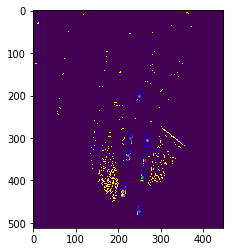

In [37]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

img = (lidar_image*255. + 0.)

img = np.clip(np.mean(img[:, :, 5:25], 2), 0, 1)

ax.imshow(img)

# print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    d = label[i][5] 
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    plt.scatter([y], [x], s=3)
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=.75,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
    print(x, y, z, w, h, d, -label[i][6]*57.2958)

# plt.imshow(temp)
plt.show()


472.48097740610626 249.16122613804237 27.466894307628436 24.00149925368652 9.28681659952163 15.30581085852821 -98.54877600000002
424.9929317312524 211.05142819540308 26.18942373151885 28.22771262209276 9.607855791839205 13.940961482608502 -100.840608
391.1555972604508 257.0877709495571 26.364184090276634 23.239160838355325 8.989174544173867 14.72087541170548 -97.40286
351.2131905251017 262.7840265944085 25.70871325222467 29.317554092563466 9.824308244325316 14.135939964882745 -100.26765000000002
339.7720150870124 222.26754487852784 26.16483546169767 27.04202514527551 9.518475543921216 15.013343135116841 -101.986524
300.69322321354207 227.96388391072577 25.521592648354662 23.882541549395164 8.62339255908189 14.525896929431235 -102.559482
304.5665045610459 268.4149090210218 26.41978390064676 31.269821417509014 9.305816739808408 14.915853893979724 -99.69469200000002
201.51041526606144 249.51731142165195 25.099899745868065 24.090049285090245 8.589393750842019 15.988235546488069 -115.737516

<Figure size 432x288 with 0 Axes>

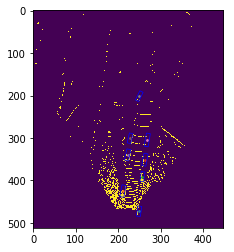

In [38]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

img = (lidar_image*255. + 0.)

img = np.clip(np.mean(img[:, :, :], 2), 0, 1)

ax.imshow(img)

# print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    d = label[i][5] 
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    plt.scatter([y], [x], s=3)
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=.75,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
    print(x, y, z, w, h, d, -label[i][6]*57.2958)

# plt.imshow(temp)
plt.show()


<Figure size 432x288 with 0 Axes>

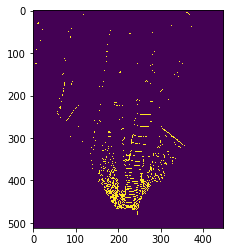

In [41]:
plt.clf()
fig,ax = plt.subplots(1)

img = (lidar_image*255. + 0.)

img = np.clip(np.mean(img[:, :, :40], 2), 0, 1)

ax.imshow(img)


<Figure size 432x288 with 0 Axes>

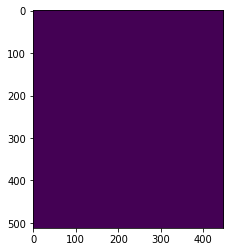

In [42]:
plt.clf()
fig,ax = plt.subplots(1)
img = (lidar_image*255. + 0.)
img = img[:, :, -1]
plt.imshow(img)
plt.show()


<Figure size 432x288 with 0 Axes>

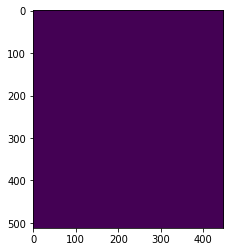

<Figure size 432x288 with 0 Axes>

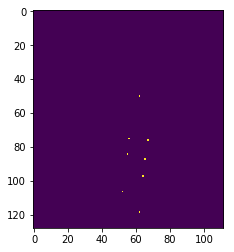

In [43]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)
img = (lidar_image*255. + 0.)
img = img[:, :, -1]
plt.imshow(img>=100)
plt.show()

plt.clf()
fig,ax = plt.subplots(1)
temp = label2[:, :, 1, -1]*255.
# temp = cv2.resize(temp, (448, 512)) * 255.
plt.imshow(temp>100)
plt.show()

15.30581085852821 9.28681659952163 24.00149925368652
249.16122613804237 27.466894307628436 472.48097740610626
13.940961482608502 9.607855791839205 28.22771262209276
211.05142819540308 26.18942373151885 424.9929317312524
14.72087541170548 8.989174544173867 23.239160838355325
257.0877709495571 26.364184090276634 391.1555972604508
14.135939964882745 9.824308244325316 29.317554092563466
262.7840265944085 25.70871325222467 351.2131905251017
15.013343135116841 9.518475543921216 27.04202514527551
222.26754487852784 26.16483546169767 339.7720150870124
14.525896929431235 8.62339255908189 23.882541549395164
227.96388391072577 25.521592648354662 300.69322321354207
14.915853893979724 9.305816739808408 31.269821417509014
268.4149090210218 26.41978390064676 304.5665045610459
15.988235546488069 8.589393750842019 24.090049285090245
249.51731142165195 25.099899745868065 201.51041526606144


<Figure size 432x288 with 0 Axes>

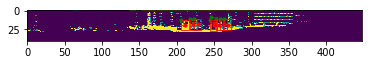

In [44]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

img = (lidar_image*255. + 0.)
# Display the image
img = np.clip(np.mean(img.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z-h/2, s=10, c='r')
    plt.scatter(y-w/2, z-h, s=10, c='g')
    a = label[i][6]
    if a < 0:
      a = a + 3.14
    print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle=0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
#     break


plt.show()


<Figure size 432x288 with 0 Axes>

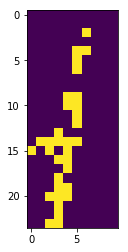

In [45]:
plt.clf()
fig,ax = plt.subplots(1)
# 338.0429604813074 228.30154100755286 26.251612833821447 22.992421447451175 9.299607994828627 15.695767823076704 -95.111028

img = (lidar_image*255. + 0.)
img = np.clip(np.mean(img[338-12:338+12, 228-5:228+5, 5:25], 2), 0, 1)
ax.imshow(img)
plt.show()

<Figure size 432x288 with 0 Axes>

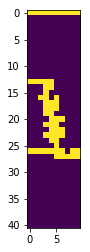

In [46]:
plt.clf()
fig,ax = plt.subplots(1)
# 15.695767823076704 9.299607994828627 22.992421447451175
# 228.30154100755286 26.251612833821447 338.0429604813074


# 15.695767823076704 9.27595552418579 23.02796916185907
# 217.70232382225657 26.251612833821447 316.5861802528655
img = (lidar_image*255. + 0.)
img = np.clip(np.mean(img.transpose()[:, 228-5:228+5, 338-11:338+11], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)
plt.show()

In [64]:
def cart2hom(pts_3d):
    ''' Input: nx3 points in Cartesian
        Oupput: nx4 points in Homogeneous by pending 1
    '''
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
    return pts_3d_hom

def project_velo_to_ref(pts_3d_velo, Tr_velo_to_cam):
    pts_3d_velo = cart2hom(pts_3d_velo) # nx4
    return np.dot(pts_3d_velo, np.transpose(Tr_velo_to_cam))

    
def project_ref_to_rect(pts_3d_ref, R0_rect):
        ''' Input and Output are nx3 points '''
        return np.transpose(np.dot(R0_rect, np.transpose(pts_3d_ref)))

def ProjectTo2Dbbox(center, h, w, l, r_y, P2):
    # input: 3Dbbox in (rectified) camera coords

    Rmat = np.asarray([[math.cos(r_y), 0, math.sin(r_y)],
                       [0, 1, 0],
                       [-math.sin(r_y), 0, math.cos(r_y)]],
                       dtype='float32')

    p0 = center + np.dot(Rmat, np.asarray([l/2.0, 0, w/2.0], dtype='float32').flatten())
    p1 = center + np.dot(Rmat, np.asarray([-l/2.0, 0, w/2.0], dtype='float32').flatten())
    p2 = center + np.dot(Rmat, np.asarray([-l/2.0, 0, -w/2.0], dtype='float32').flatten())
    p3 = center + np.dot(Rmat, np.asarray([l/2.0, 0, -w/2.0], dtype='float32').flatten())
    p4 = center + np.dot(Rmat, np.asarray([l/2.0, -h, w/2.0], dtype='float32').flatten())
    p5 = center + np.dot(Rmat, np.asarray([-l/2.0, -h, w/2.0], dtype='float32').flatten())
    p6 = center + np.dot(Rmat, np.asarray([-l/2.0, -h, -w/2.0], dtype='float32').flatten())
    p7 = center + np.dot(Rmat, np.asarray([l/2.0, -h, -w/2.0], dtype='float32').flatten())

    points = np.array([p0, p1, p2, p3, p4, p5, p6, p7])

    points_hom = np.ones((points.shape[0], 4)) # (shape: (8, 4))
    points_hom[:, 0:3] = points

    # project the points onto the image plane (homogeneous coords):
    img_points_hom = np.dot(P2, points_hom.T).T # (shape: (8, 3)) (points_hom.T has shape (4, 8))
    # normalize:
    img_points = np.zeros((img_points_hom.shape[0], 2)) # (shape: (8, 2))
    img_points[:, 0] = img_points_hom[:, 0]/img_points_hom[:, 2]
    img_points[:, 1] = img_points_hom[:, 1]/img_points_hom[:, 2]

    u_min = np.min(img_points[:, 0])
    v_min = np.min(img_points[:, 1])
    u_max = np.max(img_points[:, 0])
    v_max = np.max(img_points[:, 1])

    left = int(u_min)
    top = int(v_min)
    right = int(u_max)
    bottom = int(v_max)

    projected_2Dbbox = [left, top, right, bottom]

    return projected_2Dbbox


In [84]:
def sigmoid(x):
    x = x.astype(np.float128)
    x = 1 / (1 + np.exp(-x))
    x = x.astype(np.float32)
    return x

def convert_prediction_into_real_values(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(512, 448), output_size=(128, 112), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    if not is_label:
        ones_index = np.where(sigmoid(label_tensor[:, :, :, -1])>=th)
    else:
        ones_index = np.where(label_tensor[:, :, :, -1]>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, :, -1]>=th)
#     print(ones_index)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], ones_index[2][i], :])
            anchor = np.array([x+0.5, y+0.5, 1., anchors[0], anchors[1], anchors[2]])

            out[:3] = out[:3] * anchor[3:6] + anchor[:3]
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 40
            
            out[3:6] = np.exp(out[3:6]) * anchors
            
            k = ones_index[2][i]
            if not is_label:
              out[6] = sigmoid(out[6]) * np.pi/2 - np.pi/4
            else:
                out[6] = out[6]
            
            if k == 0 and out[6] < 0:
                out[6] = out[6] + np.pi
                
            out[6] = out[6] + k * (np.pi/2)
                        
            result.append(out)
            
    return np.array(result)

In [85]:
def get_points(converted_points, calib_path, 
                x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                size=(512, 448, 40), th=0.5):
    all_result = []
    for converted_points_ in converted_points:
        if converted_points_[-1] >= th:
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8] = converted_points_[5]
            result[9] = converted_points_[4]
            result[10] = converted_points_[3]
            result[14] = converted_points_[6]
            result[15] = sigmoid(converted_points_[-1])

            
            calib_reader = CalibReader(calib_path)
            calib_data = calib_reader.read_calib()

            # x_range=(0, 70)
            # y_range=(-40, 40)
            # z_range=(-2.5, 1)

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size

            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, -1*y_range[0], -1*z_range[0]]) 
            point = np.array([[x, y, z]])
            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))
            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]
            for k in range(3):
                result[11 + k] = pts_3d_ref[k]

            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[5], converted_points_[4],
                         converted_points_[3], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox
            all_result.append(result)
    return all_result

In [86]:
th=0.5
# truth_value = None
converted_points = convert_prediction_into_real_values(label2, truth_value=None, th=th, is_label=True)
print(len(converted_points))
# converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
points = get_points(converted_points, list_calib_paths[i_c], th=th)
print(converted_points)
res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
print(res)

8
[[201.51042   249.51732    25.0999      3.48        1.45        1.6400001
    2.02        1.          1.       ]
 [300.69324   227.96388    25.521593    3.35        1.52        1.49
    1.79        1.          1.       ]
 [304.5665    268.41492    26.419783    4.37        1.65        1.53
    1.74        0.          1.       ]
 [339.772     222.26755    26.164835    3.79        1.68        1.54
    1.78        1.          1.       ]
 [351.2132    262.78403    25.708714    4.1         1.74        1.4499999
    1.75        0.          1.       ]
 [391.1556    257.08777    26.364183    3.24        1.6         1.51
    1.7         0.          1.       ]
 [424.99292   211.05142    26.189423    3.9499998   1.7         1.43
    1.76        1.          1.       ]
 [472.481     249.16122    27.466896    3.35        1.65        1.5699999
    1.72        0.          1.       ]]
Car -1 -1 -10 664 175 707 204 1.6400001 1.45 3.48 4.50000102280246 1.800000140509439 42.850002983386354 2.02 0.7310586

In [87]:
t = list_label_paths[i_c]
!cat $t

Car 0.80 0 -2.09 1013.39 182.46 1241.00 374.00 1.57 1.65 3.35 4.43 1.65 5.20 -1.42
Car 0.00 0 1.95 354.43 185.52 549.52 294.49 1.43 1.70 3.95 -2.39 1.66 11.80 1.76
Pedestrian 0.00 2 1.41 859.54 159.80 879.68 221.40 1.96 0.72 1.09 8.33 1.55 23.51 1.75
Car 0.00 0 -1.78 819.63 178.12 926.85 251.56 1.51 1.60 3.24 5.85 1.64 16.50 -1.44
Car 0.00 2 -1.69 800.54 178.06 878.75 230.56 1.45 1.74 4.10 6.87 1.62 22.05 -1.39
Car 0.00 0 1.80 558.55 179.04 635.05 230.61 1.54 1.68 3.79 -0.38 1.76 23.64 1.78
Car 0.00 2 1.77 598.30 178.68 652.25 218.17 1.49 1.52 3.35 0.64 1.74 29.07 1.79
Car 0.00 1 -1.67 784.59 178.04 839.98 220.10 1.53 1.65 4.37 7.88 1.75 28.53 -1.40
Car 0.00 1 1.92 663.74 175.36 707.21 204.15 1.64 1.45 3.48 4.50 1.80 42.85 2.02
DontCare -1 -1 -10 737.69 163.56 790.86 197.98 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 135.60 185.44 196.06 202.15 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 796.02 162.52 862.73 183.40 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 879.35 16